# Python: A/B Testing with DoubleML

<img src="figures/ab_testing.jpg" alt="An illustration of A/B testing." style="width: 400px;"/>

Image Source Freepik http://www.freepik.com, Designed by macrovector


In this notebook, we demontrate exemplarily how the [DoubleML](https://docs.doubleml.org/stable/index.html) package can be used to estimate the causal effect of seeing a new ad design on customers' purchases in a webshop.

## A/B Testing

A/B testing is a frequently used framework to perform causal inference in practice. For example, a manager of a webshop might want to optimally adapt the webshop design according to users' preferences. For instance, she might want to estimate the effect of a new ad design, which is displayed on the starting page, on customers' purchases (in $100\$$). A/B tests refer to an experimental design in which a certain treatment, for example a new ad design (called "Version $A$"), is randomly assigned to groups of individuals, like website visitors or app users. If a user is not "treated", i.e., he is not exposed to Version $A$, he sees an alternative design "Version $B$" like the old design of the ad. The assignment of the treatment might either be unconditionally random, i.e., randomly assigned to all visitors of the online shop or directed towards specific groups of them. In the latter case, the treatment assignment would be provided conditional on their characteristics, like their shopping history. An example would be a discount that is only granted to loyal customers who already made some purchases in the past.

In general, the goal of the A/B test is to assess whether the treatment has an effect on the outcome variable of interest. In our example, the manager wants to evaluate whether the new ad design changed the monetary value of products purchased (in $100\$$) on average. Alternative settings of A/B tests refer to improvement of a user experience on a website or estimation of price elasticities. Websites and apps are ideal for running A/B tests because they make it very easy to precisely direct the treatment to visitors and users (or to specific subgroups of them) as well as to collect the data required for evaluation of the intervention.

## Scenario

Let's consider the following stylized scenario. The manager of a webshop performs an A/B test to estimate the effect a new ad design $A$ has on customers' purchases, $Y$, on average. This effect is called the **A**verage **T**reatment **E**ffect (**ATE**). The treatment is assigned randomly conditional on the visitors' characteristics, which we call $V$. Such characteristics could be collected from a customer's shoppers account, for example. These might include the number of previous purchases, time since the last purchase, length of stay on a page as well as whether a customer has a rewards card, among other characteristics. <br> 

In the following, we use a **D**irected **A**cyclical **G**raph (DAG) to illustrate our assumptions on the causal structure of the scenario. As not only the outcome, but also the treatment is dependent on the individual characteristics, there are arrows going from $V$ to both $A$ and $Y$. In our example, we also assume that the treatment $A$ is a direct cause of the customers' purchases $Y$.


![Scenario illustration with a DAG](figures/DAG.svg)



Let's assume the conditional randomization has been conducted properly, such that a tidy data set has been collected. Now, a data scientist wants to evaluate whether the new ad design causally affected the sales, by using the [DoubleML](https://docs.doubleml.org/stable/index.html) package.

### Why control for individual characteristics?

Before we start the case study, let us briefly address the question why we need to include individual characteristics in our analysis at all. There are mainly two reasons why we want to control for observable characteristics. First, so-called confounders, i.e., variables that have a causal effect on both the treatment variable and the outcome variable, possibly create a bias in our estimate. In order to uncover the true causal effect of the treatment, it is necessary that our causal framework takes all confounding variables into account. Otherwise, the average causal effect of the treatment on the outcome is not identified. A second reason to include individual characteristics is efficiency. The more variation can be explained within our causal framework, the more precise will be the resulting estimate. In practical terms, greater efficiency leads to tighter confidence intervals and smaller standard errors and p-values. This might help to improve the power of A/B tests even if the treatment variable is unconditionally assigned to individuals.

### Why use machine learning to analyze A/B tests?

ML methods have turned out to be very flexible in terms of modeling complex relationships of explanatory variables and dependent variables and, thus, have exhibited a great predictive performance in many applications. In the double machine learning approach ([Chernozhukov et al. (2018)](https://arxiv.org/abs/1608.00060)), ML methods are used for modelling so-called nuisance functions. In terms of the A/B case study considered here, ML tools can be used to flexibly control for confounding variables. For example, a linear parametric specification as in a standard linear regression model might not be correct and, hence, not sufficient to account for the underlying confounding. Moreover, by using powerful ML techniques, the causal model will likely be able to explain a greater share of the total variation and, hence, lead to more precise estimation.

## Data 

As an illustrative example we use a data set from the [ACIC 2019 Data Challenge](https://sites.google.com/view/acic2019datachallenge/data-challenge). In this challenge, a great number of data sets have been generated in a way that they mimic distributional relationships that are found in many economic real data applications. Although the data have not been generated explicitly to address an A/B testing case study, they are well-suited for demonstration purposes. We will focus on one of the many different data genereting processes (DGP) that we picked at random, in this particualar case a data set called `high42`. An advantage of using the synthetic [ACIC 2019 data](https://sites.google.com/view/acic2019datachallenge/data-challenge) is that we know the true average treatment effect which is 0.8 in our data set.

First we load the data.

In [1]:
import pandas as pd

# Load data set from url (internet connection required)
url = 'https://raw.githubusercontent.com/DoubleML/doubleml-docs/master/doc/examples/data/high42.CSV'
df = pd.read_csv(url)

In [2]:
print(df.shape)

(1000, 202)


In [3]:
df.head()

,Y,A,V1,V2,V3,V4,V5,V6,V7,V8,...,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200
0,7.358185,1,10,0,0,7,192.793769,23.676950,8,0.185443,...,1.462837,1,1627.274196,0,0,4.683956,0.565667,0,3,0.024338
1,8.333672,1,12,0,1,4,199.653596,19.281270,7,0.514842,...,1.330522,1,1661.484439,1,0,6.766661,-0.395402,0,4,0.056518
2,7.472758,0,14,1,1,2,194.207792,24.589331,5,0.309199,...,1.384151,1,1658.939293,0,0,5.647794,1.112766,0,0,0.013442
3,6.502319,1,0,1,0,9,201.838024,25.513918,4,0.160160,...,1.220303,1,1650.801625,0,0,5.370363,-0.305842,0,4,0.034632
4,7.043758,1,12,0,0,9,201.360443,31.160641,6,0.291976,...,1.170094,1,1676.818876,0,0,3.446532,2.440661,0,1,0.017514


We see that the data set consists of 1000 observations (= website visitors) and 202 variables. The $Y$ column represents the customers' purchases (in $100\$$). The treatment variable $A$ is binary with a value 1 indicating that a customer has been exposed to the new ad design (and value 0 otherwise). The remaining 200 columns $V$ represent individual characteristics of the customers.

### Descriptive Statistics


Once we loaded the data, we find that the outcome variable, $Y$, is continuous with mean around $7.33$. The treatment variable $A$ is binary with a value of $1$ indicating that a visitor was exposed to the new ad design $A$ as opposed to design $B$ (corresponding to a value of the treatment variable $A$ equal to $1$). The control variables $V$ are a collection of mixed data types, including continuous, discrete and binary variables.

In [4]:
df.describe()

,Y,A,V1,V2,V3,V4,V5,V6,V7,V8,...,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000
mean,7.331239,0.443000,9.290000,0.377000,0.616000,6.477000,200.088758,28.066028,6.031000,0.294206,...,1.318209,0.94200,1667.454561,0.254000,0.174000,5.804205,-0.076921,0.29400,1.629000,0.037936
std,1.379852,0.496989,3.889605,0.484877,0.486601,2.870141,6.105408,9.920941,2.480361,0.119454,...,0.270178,0.23386,44.191913,0.435515,0.379299,2.655835,1.002754,0.45582,1.388988,0.021688
min,3.435052,0.000000,0.000000,0.000000,0.000000,0.000000,183.123067,12.020630,0.000000,0.047160,...,0.668093,0.00000,1524.291675,0.000000,0.000000,1.097708,-3.644652,0.00000,0.000000,0.001478
25%,6.405583,0.000000,7.000000,0.000000,0.000000,5.000000,195.941569,21.206230,4.000000,0.204260,...,1.119369,1.00000,1637.699514,0.000000,0.000000,4.065465,-0.751355,0.00000,1.000000,0.021711
50%,7.335248,0.000000,10.000000,0.000000,1.000000,7.000000,199.876117,26.202582,6.000000,0.282867,...,1.293790,1.00000,1667.763480,0.000000,0.000000,5.236465,-0.091056,0.00000,1.000000,0.034009
75%,8.271881,1.000000,12.000000,1.000000,1.000000,8.000000,204.398067,33.071189,8.000000,0.374078,...,1.476828,1.00000,1695.972631,1.000000,0.000000,6.898240,0.594647,1.00000,2.000000,0.049100
max,13.197260,1.000000,20.000000,1.000000,1.000000,15.000000,220.584410,95.410020,14.000000,0.706249,...,2.448661,1.00000,1825.697096,1.000000,1.000000,38.427974,2.832673,1.00000,9.000000,0.139716


From the explanatory variables $V1$ to $V200$, 107 variables are continuous, while 95 are integers. From the integer-variables 59 are binary variables. 

In [5]:
print(df.dtypes.value_counts())
print("Number of binary variables:", len(df[df.columns[df.isin([0,1]).all()]].columns))

float64    107
int64       95
dtype: int64
Number of binary variables: 59


Let's continue with some visual inspection.

In [6]:
# Define the settings for the graphs first
import seaborn as sns
sns.set()
colors = sns.color_palette()

import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = 5., 3.75
sns.set(font_scale=1.5)
sns.set_style('whitegrid', {'axes.spines.top': False,
                            'axes.spines.bottom': False,
                            'axes.spines.left': False,
                            'axes.spines.right': False})

The first figure shows that 443 out of the 1000 customers have been exposed to the new ad design.

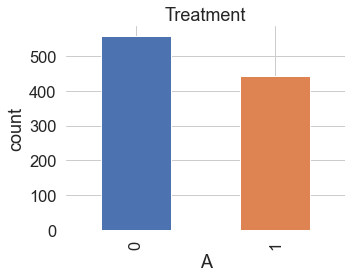

In [7]:
df['A'].value_counts().plot(kind='bar', color=colors)

plt.title('Treatment')
plt.xlabel('A')
_ = plt.ylabel('count')

### Unconditional Estimate of ATE

As a first naive estimate, we could calculate the unconditional average treatment effect. In other words, we simply take the difference between $Y$ observed for the customers who have been exposed to the treatment $(A=1)$ and those who haven't been exposed $(A=0)$. As a visualization, we plot the density of the outcome variable separately for those who have been exposed to the new ad and those who have not to get a first impression on the descriptive relationship of $A$ and $Y$.

Since the unconditional ATE does not account for the confounding variables, it will generally not correspond to the true ATE (only in the case of unconditionally random treatment assignment, the unconditional ATE will correspond to the true ATE). For example, if the unconditional ATE estimate is greater than the actual ATE, the manager would erroneously overinterpret the effect of the new ad design and probably make misleading decisions for the marketing budget in the future.

In [9]:
df[['A', 'Y']].groupby('A').mean()

,Y
A,
0,6.836141
1,7.953744


In [10]:
df[['A', 'Y']].groupby('A').mean().diff()

,Y
A,
0,NaN
1,1.117603


The uncoditional effect is around $1.118$. Because we use a simulated data set in this example, we know that the true effect is $0.8$. Therefore the unconditional ATE overestimates the true effect, because it does not account for the confounding variables. In order to get an estimate for the ATE that explicitly takes the confounding variables $V$ into account, we apply the [DoubleML](https://docs.doubleml.org/stable/index.html) package in the next section.

## Estimate ATE with the `DoubleML` package

Let’s use the package [DoubleML](https://docs.doubleml.org/stable/index.html) to estimate the average treatment effect of the new ad design on the value of customers' purchases. First, the required packages are imported.

In [11]:
import numpy as np
import pandas as pd
import doubleml as dml

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LassoCV, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn.metrics import log_loss
from xgboost import XGBClassifier, XGBRegressor

import matplotlib.pyplot as plt
import scipy.stats as stats

### The Data Backend: `DoubleMLData`

To start our analysis, we initialize the data backend from the previously loaded data set, i.e., we create a new instance of a [DoubleMLData](https://docs.doubleml.org/stable/api/generated/doubleml.DoubleMLData.html#doubleml.DoubleMLData) object. During initialization, we specify the roles of the variables in the data set, i.e., in our example the outcome variable $Y$ via the parameter `y_col`, the treatment variable $A$ via `d_cols` and the confounding variables $V$ via `x_cols`.

In [12]:
# Specify explanatory variables for data-backend
features_base = list(df.columns.values)[2:]

# Initialize DoubleMLData (data-backend of DoubleML)
data_dml = dml.DoubleMLData(df,
                            y_col='Y',
                            d_cols='A',
                            x_cols=features_base)

We can print the data-backend to see the variables, which we have assigned as outcome, treatment and controls.

In [13]:
print(data_dml)

================== DoubleMLData Object ==================

------------------ Data summary      ------------------
Outcome variable: Y
Treatment variable(s): ['A']
Covariates: ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V82', 'V83', 'V84', 'V85', 'V86', 'V87', 'V88', 'V89', 'V90', 'V91', 'V92', 'V93', 'V94', 'V95', 'V96', 'V97', 'V98', 'V99', 'V100', 'V101', 'V102', 'V103', 'V104', 'V105', 'V106', 'V107', 'V108', 'V109', 'V110', 'V111', 'V112', 'V113', 'V114', 'V115', 'V116', 'V1

## The Inference Problem and Choosing an Appropriate Model

The inference problem is to determine the causal effect of seeing the new ad design $A$ on customers' purchases $Y$ once we control for individual characteristics $V$. In our example, we are interested in the average treatment effect. Basically, there are two causal models available in [DoubleMLData](https://docs.doubleml.org/stable/api/generated/doubleml.DoubleMLData.html#doubleml.DoubleMLData) that can be used to estimate the ATE.

The so-called interactive regression model (IRM) called by [DoubleMLIRM](https://docs.doubleml.org/stable/api/generated/doubleml.DoubleMLIRM.html) is a flexible (nonparametric) model to estimate this causal quantity. The model does not impose functional form restrictions on the underlying regression relationships, for example, linearity or additivity as in a standard linear regression model. This means that the model hosts heterogeneous treatment effects, i.e., account for variation in the effect of the new ad design across customers. Moreover, it is possible to also estimate other causal parameters with the IRM, for example, the average treatment effect on the treated (= those customers who have been exposed to the new ad), which might be of interest too.

The second causal model that can be used here is the partially linear regression model (PLR). The PLR incorporates stronger assumptions, for example, that the treatment effect is additive and constant, i.e., in the model it is assumed that the effect does not very across individuals. We will start with the IRM and include the PLR estimates at the end of the notebook.

## 1. Interactive Regression Model (IRM)

We briefly introduce the [Interactive Regression Model](https://docs.doubleml.org/stable/guide/models.html#interactive-regression-model-irm) (IRM) where the main regression relationship of interest is provided by

$$Y = g_0(D, X) + U, \quad E(U | X, D) = 0,$$

where the treatment variable is binary, $D \in \lbrace 0,1 \rbrace$. We consider estimation of the average treatment effect (ATE):

$$\theta_0 = \mathbb{E}[g_0(1, X) - g_0(0,X)],$$

when treatment effects are heterogeneous. In order to be able to use ML methods, the estimation framework generally requires a property called "double robustness" or "Neyman orthogonality". In the IRM, double robustness can be achieved by including the first-stage estimation

$$D = m_0(X) + V, \quad E(V | X) = 0,$$

which amounts to estimation of the propensity score, i.e., the probability that a customer is exposed to the treatment provided her observed characteristics. Both predictions are then combined in [the doubly robust score for the average treatment effect](https://docs.doubleml.org/stable/guide/scores.html#interactive-regression-model-irm) which is given by

$$\psi(W; \theta, \eta) := g(1,X) - g(0,X) + \frac{D (Y - g(1,X))}{m(X)} - \frac{(1 - D)(Y - g(0,X))}{1 - m(x)} - \theta.$$

Because the data set was simulated we are aware of the true ATE, $\theta_0=0.8$. The interpretation of this is that exposure to the new ad increases sales (in $100\$$) by around $0.8$ on average. In the following, we try to estimate this causal effect using the [DoubleML](https://docs.doubleml.org/stable/index.html) package and assess whether the estimated effect is significantly different from zero.

### Assess Predictive Performance in the IRM

In the following, we will compare the estimate of the ATE based on different learners. Moreover, we will also have a look how well the learners can predict the nuisance components of the causal model. 

To evaluate the predictive performance, we'll first define a helper function that uses a DoubleML model object and returns a summary for a predictive measure. We'll use the root mean squared error (RMSE) for the main regression and the log loss measure $L_{log}$ for the propensity score estimation.

Estimation of the IRM delivers two arrays for the prediction function $g_0(D, X)$: `ml_g0` for $g_0(0, X)$ and `ml_g1` for $g_0(1, X)$. If we want to get the correct prediction for each observation based on the treatment realization, we pick the corresponding value of either `ml_g0` (for $D=0$) or `ml_g1` (for $D=1$). As we apply random sample splitting repeatedly in every model, the RMSE and the log loss can be calculated for each repetition. We are interested in mean and standard deviation across all repetitions.

In [14]:
def pred_acc_irm(DoubleML, prop):
    """
    A function to calculate prediction accuracy values for every repetition
    of a Double Machine Learning model using IRM, DoubleMLIRM
    
    ...
    
    Parameters
    ----------
    DoubleML : doubleml.double_ml_irm.DoubleMLIRM
        The IRM Double Machine Learning model
    prop : bool
        Indication if RMSE values have to be computed for main regression or
        log loss values for propensity score
    """
    
    # export data and predictions of the DoubleML model
    y = DoubleML._dml_data.y
    d = DoubleML._dml_data.d
    g0 = DoubleML.predictions.get('ml_g0')
    g1 = DoubleML.predictions.get('ml_g1')    
    m = DoubleML.predictions.get('ml_m')
    
    # dimensions of prediction array
    h = g0.shape[0]
    w = DoubleML.n_rep
    
    # check whether treatment is binary 
    if np.isin(d, [0,1]).all() == False:
        raise ValueError("Treatment must be a binary variable.")
    
    # prepare array to store prediction accuracy measure values
    pred_acc_array = np.zeros((w,))
    
    # check whether to assess main regression or propensity score accuracy:   
    if prop == False:
        
        # evaluate main regression accuracy
        # export an array with correctly picked prediction values    
        export_pred_array = np.zeros((h, w))            
        for i in range(w):
            for j in range(h):
                if d[j] == 0:
                    export_pred_array[j,i] = g0[j,i]
                else:
                    export_pred_array[j,i] = g1[j,i]
    
        # fill array that contains rmse of each repetition
        for i in range(w):
            pred_acc_array[i] = mean_squared_error(y, export_pred_array[:,i], squared=False)    
    else:
        
        # evaluate propensity score accuracy
        # fill array that contains log loss of each repetition
        for i in range(w):
            pred_acc_array[i] = log_loss(d, m[:,i], eps=0.025)
    
    return pred_acc_array

### Benchmark: Model based on Linear and Logistic Regression

Let us first start with a benchmark model that is based on linear and logistic regression. Hence, we estimate the functions $g_0(D,X)$ using a linear regression model and $m_0(X)$ by using an (unpenalized) logistic regression. In both cases, we include all available characteristics $V$. Later we will assess whether we can find a "better" estimator based on ML methods like lasso, random forests and boosting. Because we have 200 variables and 1000 observations, this is approaching a high dimentional setting, therefore the linear and the logistic regression may not estimate the parameters well.

We start by initializing the learners for linear regression and logistic regression. Then, we initialize a causal model object, here of the class [DoubleMLIRM](https://docs.doubleml.org/stable/api/generated/doubleml.DoubleMLIRM.html). The latter is based on the data-backend we have specified above. To reduce the disproportionate impact of extreme propensity score weights in the interactive model we trim the propensity score from below and above at thresholds of 0.025 and 0.975. For estimation, we perform 3-fold cross-fitting with 3 repetitions. Although this is not required for valid estimation of the ATE in the model with linear and logistic regression, we use cross-fitting algorithm to have a comparable evaluation of the nuisance estimation. As defined in the previous helper function `pred_acc_irm`, we compare the predictive performance of the nuisance learners based on hold-out/test observations.

In [15]:
# Initialize Linear and Logistic Regression learners
linreg = make_pipeline(StandardScaler(), LinearRegression())
logreg_class = make_pipeline(StandardScaler(), LogisticRegression(penalty="none"))

# Initialize DoubleMLIRM model
np.random.seed(1234)
dml_irm_regression = dml.DoubleMLIRM(data_dml,
                                ml_g = linreg,
                                ml_m = logreg_class,
                                trimming_threshold = 0.025,
                                n_folds = 3,
                                n_rep = 3)

dml_irm_regression.fit(store_predictions=True)

reg_summary = dml_irm_regression.summary
reg_summary

,coef,std err,t,P>|t|,2.5 %,97.5 %
A,1.057833,0.624814,1.693035,0.090449,-0.166781,2.282446


In [16]:
print("Bias:", dml_irm_regression.coef - 0.8)

Bias: [0.25783258]


We see that the causal estimate suffers from a substantial bias and is quite noisy: The ATE is overestimated by around 0.26 and the standard error is around 0.62. The corresponding 95%-confidence interval is relatively wide. It even covers the value of zero. Hence, we cannot reject the null hypothesis that the average treatment effect is different from zero at the 5% significance level.

Next, we'll calculate the RMSE and the log loss for the nuisance functions in order to find out how the benchmark compares to other ML models.

In [17]:
# calculate mean and standard deviation of repetition RMSE's to evaluate main regression accuracy
rmse_main_linlog_irm = pred_acc_irm(dml_irm_regression, prop=False)
rmse_main_linlog_irm_mean = np.mean(rmse_main_linlog_irm)
rmse_main_linlog_irm_std = np.std(rmse_main_linlog_irm)

# calculate mean and standard deviation of repetition log losses to evaluate propensity score accuracy
logloss_prop_linlog_irm = pred_acc_irm(dml_irm_regression, prop=True)
logloss_prop_linlog_irm_mean = np.mean(logloss_prop_linlog_irm)
logloss_prop_linlog_irm_std = np.std(logloss_prop_linlog_irm)

In [18]:
print("Mean of the main regression RMSE across 3 repetitions is", rmse_main_linlog_irm_mean)
print("Standard deviation of the RMSE is", rmse_main_linlog_irm_std)

Mean of the main regression RMSE across 3 repetitions is 1.727905012276966
Standard deviation of the RMSE is 0.026526079197961804


In [19]:
print("Mean of the propensity score's log loss across 3 repetitions is", logloss_prop_linlog_irm_mean)
print("Standard deviation of log loss is", logloss_prop_linlog_irm_std)

Mean of the propensity score's log loss across 3 repetitions is 1.0228568161263911
Standard deviation of log loss is 0.027536454508812133


Next, let us find out if we are able to use ML methods to find estimators that have a lower bias and a smaller standard error than the benchmark.

### Double Machine Learning based on Lasso

We estimate the nuisance components $g_0$ and $m_0$ using lasso as provided by [scikit-learn](https://scikit-learn.org). We load the learner by initializing instances from the classes [LassoCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html) and [LogisticRegressionCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html). Here we specify that the lasso should use the value of $\lambda$ that minimizes the cross-validated mean squared error, which is based on 5-fold cross validation. We initialize the [DoubleMLIRM](https://docs.doubleml.org/stable/api/generated/doubleml.DoubleMLIRM.html) object and use the newly defined learners.

In [20]:
# Initialize Lasso learners
lasso = make_pipeline(StandardScaler(), LassoCV(cv=5, max_iter=20000))      
lasso_class = make_pipeline(StandardScaler(),
                            LogisticRegressionCV(cv=5, penalty='l1', solver='liblinear',     
                                                 Cs = 4, max_iter=1000))      

# Initialize DoubleMLIRM model
np.random.seed(1234)
dml_irm_lasso = dml.DoubleMLIRM(data_dml,
                          ml_g = lasso,
                          ml_m = lasso_class,
                          trimming_threshold = 0.025,                          
                          n_folds = 3,
                          n_rep = 3)

dml_irm_lasso.fit(store_predictions=True)

lasso_summary = dml_irm_lasso.summary
lasso_summary

,coef,std err,t,P>|t|,2.5 %,97.5 %
A,0.855559,0.070928,12.062417,1.668137e-33,0.716544,0.994575


In [21]:
print("Bias:", dml_irm_lasso.coef - 0.8)

Bias: [0.05555945]


In [22]:
# calculate mean and standard deviation of repetition RMSE's to evaluate main regression accuracy
rmse_main_lasso_irm = pred_acc_irm(dml_irm_lasso, prop=False)
rmse_main_lasso_irm_mean = np.mean(rmse_main_lasso_irm)
rmse_main_lasso_irm_std = np.std(rmse_main_lasso_irm)

# calculate mean and standard deviation of repetition log losses to evaluate propensity score accuracy
logloss_prop_lasso_irm = pred_acc_irm(dml_irm_lasso, prop=True)
logloss_prop_lasso_irm_mean = np.mean(logloss_prop_lasso_irm)
logloss_prop_lasso_irm_std = np.std(logloss_prop_lasso_irm)

In [23]:
print("Mean of the main regression RMSE across 3 repetitions is", rmse_main_lasso_irm_mean)
print("Standard deviation of RMSE is", rmse_main_lasso_irm_std)

Mean of the main regression RMSE across 3 repetitions is 1.1143405452234652
Standard deviation of RMSE is 0.005869688113839954


In [24]:
print("Mean of the propensity score's log loss across 3 repetitions is", logloss_prop_lasso_irm_mean)
print("Standard deviation of log loss is", logloss_prop_lasso_irm_std)

Mean of the propensity score's log loss across 3 repetitions is 0.6686766530020503
Standard deviation of log loss is 0.0032543941531603953


We see that the lasso-based estimate for the ATE is $0.86$ and, hence, much closer to the true value of $0.8$ than in the benchmark $1.06$. Moreover, we can achieve improvements in terms of estimation precision as can be recognized from the smaller standard error. Also the prediction measures for the nuisance components are much smaller for Lasso than in the linear/logistic benchmark. Using the Lasso learners makes it now possible to conclude that the ATE is significantly different from zero at a significance level of 5%.

### Double Machine Learning based on Random Forest

Alternatively, we can repeat this procedure with other machine learning methods, for example a random forest learner as provided by the [RandomForestRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) and [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) class in [scikit-learn](https://scikit-learn.org).

In [25]:
# Initialize Random Forest learners
randomForest = RandomForestRegressor()
randomForest_class = RandomForestClassifier()

# Initialize DoubleMLIRM model
np.random.seed(1234)
dml_irm_forest = dml.DoubleMLIRM(data_dml,
                                 ml_g = randomForest,
                                 ml_m = randomForest_class,
                                 trimming_threshold = 0.025,
                                 n_folds = 3,
                                 n_rep = 3)

# Set nuisance-part specific parameters
dml_irm_forest.set_ml_nuisance_params('ml_g0', 'A', {
    'max_features': 200, 'n_estimators': 250})
dml_irm_forest.set_ml_nuisance_params('ml_g1', 'A', {
    'max_features': 200, 'n_estimators': 250})
dml_irm_forest.set_ml_nuisance_params('ml_m', 'A', {
    'max_features': 200, 'n_estimators': 250})

dml_irm_forest.fit(store_predictions=True) 

forest_summary = dml_irm_forest.summary
forest_summary

,coef,std err,t,P>|t|,2.5 %,97.5 %
A,0.893176,0.077421,11.53655,8.631791e-31,0.741433,1.044919


In [26]:
print("Bias:", dml_irm_forest.coef - 0.8)

Bias: [0.09317591]


In [27]:
# calculate mean and standard deviation of repetition RMSE's to evaluate main regression accuracy
rmse_main_forest_irm = pred_acc_irm(dml_irm_forest, prop=False)
rmse_main_forest_irm_mean = np.mean(rmse_main_forest_irm)
rmse_main_forest_irm_std = np.std(rmse_main_forest_irm)

# calculate mean and standard deviation of repetition log losses to evaluate propensity score accuracy
logloss_prop_forest_irm = pred_acc_irm(dml_irm_forest, prop=True)
logloss_prop_forest_irm_mean = np.mean(logloss_prop_forest_irm)
logloss_prop_forest_irm_std = np.std(logloss_prop_forest_irm)

In [28]:
print("Mean of the main regression RMSE across 3 repetitions is", rmse_main_forest_irm_mean)
print("Standard deviation of RMSE is", rmse_main_forest_irm_std)

Mean of the main regression RMSE across 3 repetitions is 1.1688034544446142
Standard deviation of RMSE is 0.00826647072034282


In [29]:
print("Mean of the propensity score's log loss across 3 repetitions is", logloss_prop_forest_irm_mean)
print("Standard deviation of log loss is", logloss_prop_forest_irm_std)

Mean of the propensity score's log loss across 3 repetitions is 0.6823242335385794
Standard deviation of log loss is 0.0026223238604172463


The results are relatively similar to the one obtained by lasso with a bias and standard errors that are slightly greater than before. The predictive accuracy of the random forest learners is also slightly worse than that of Lasso.

### Double Machine Learning based on Extreme Gradient Boosting

Next, we estimate the ATE using extreme gradient boosting as provided by [xgboost](https://docs.getml.com/latest/api_reference/predictors.html).

In [30]:
# Initialize Extreme Gradient Boosting learners
boost = XGBRegressor(n_jobs=1, objective = "reg:squarederror")
boost_class = XGBClassifier(use_label_encoder=False, n_jobs=1,
                            objective = "binary:logistic", eval_metric = "logloss")

# Initialize DoubleMLIRM model
np.random.seed(1234)
dml_irm_boost = dml.DoubleMLIRM(data_dml,
                                ml_g = boost,
                                ml_m = boost_class,
                                trimming_threshold = 0.025,
                                n_folds = 3,
                                n_rep = 3)

# Set nuisance-part specific parameters
dml_irm_boost.set_ml_nuisance_params('ml_g0', 'A', {
    'n_estimators': 30, 'eta': 0.2})
dml_irm_boost.set_ml_nuisance_params('ml_g1', 'A', {
    'n_estimators': 30, 'eta': 0.2})
dml_irm_boost.set_ml_nuisance_params('ml_m', 'A', {
    'n_estimators': 15, 'eta': 0.2})

dml_irm_boost.fit(store_predictions=True)

boost_summary = dml_irm_boost.summary
boost_summary

,coef,std err,t,P>|t|,2.5 %,97.5 %
A,0.790906,0.104306,7.582588,3.387302e-14,0.586471,0.995341


In [31]:
print("Bias:", dml_irm_boost.coef - 0.8)

Bias: [-0.0090944]


In [32]:
# calculate mean and standard deviation of repetition RMSE's to evaluate main regression accuracy
rmse_main_boost_irm = pred_acc_irm(dml_irm_boost, prop=False)
rmse_main_boost_irm_mean = np.mean(rmse_main_boost_irm)
rmse_main_boost_irm_std = np.std(rmse_main_boost_irm)

# calculate mean and standard deviation of repetition log losses to evaluate propensity score accuracy
logloss_prop_boost_irm = pred_acc_irm(dml_irm_boost, prop=True)
logloss_prop_boost_irm_mean = np.mean(logloss_prop_boost_irm)
logloss_prop_boost_irm_std = np.std(logloss_prop_boost_irm)

In [33]:
print("Mean of the main regression RMSE across 3 repetitions is", rmse_main_boost_irm_mean)
print("Standard deviation of RMSE is", rmse_main_boost_irm_std)

Mean of the main regression RMSE across 3 repetitions is 1.2287566646120192
Standard deviation of RMSE is 0.010275338353331828


In [34]:
print("Mean of the propensity score's log loss across 3 repetitions is", logloss_prop_boost_irm_mean)
print("Standard deviation of log loss is", logloss_prop_boost_irm_std)

Mean of the propensity score's log loss across 3 repetitions is 0.7204831015081563
Standard deviation of log loss is 0.01297502257820836


The estimated coefficient is very close to the true ATE of $0.8$ but has a small negative bias. The interpretation of the results obtained with lasso, random forests and boosting are very similar. In all cases we are able to reject the null hypothesis that the ad has no effect on the sales.

#### IRM - Summary of coefficient estimates

We save the estimates, bias and confidence intervals for later peresentation and comparision.

In [35]:
irm_summary = pd.concat((reg_summary, lasso_summary, forest_summary, boost_summary))
irm_summary.index = ['regression','lasso', 'forest', 'xgboost']
irm_summary = irm_summary[['coef', 'std err', '2.5 %', '97.5 %']]
irm_summary.insert(1, "Bias", [irm_summary.loc['regression','coef'] - 0.8, 
                               irm_summary.loc['lasso','coef'] - 0.8, 
                               irm_summary.loc['forest','coef'] - 0.8, 
                               irm_summary.loc['xgboost','coef'] - 0.8])
irm_summary.round(3)

,coef,Bias,std err,2.5 %,97.5 %
regression,1.058,0.258,0.625,-0.167,2.282
lasso,0.856,0.056,0.071,0.717,0.995
forest,0.893,0.093,0.077,0.741,1.045
xgboost,0.791,-0.009,0.104,0.586,0.995


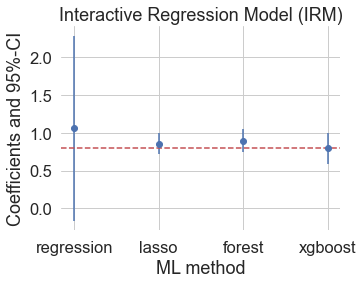

In [36]:
errors = np.full((2, irm_summary.shape[0]), np.nan)
errors[0, :] = irm_summary['coef'] - irm_summary['2.5 %']
errors[1, :] = irm_summary['97.5 %'] - irm_summary['coef']
plt.errorbar(irm_summary.index, irm_summary.coef, fmt='o', yerr=errors)
plt.axhline(y=0.8, color='r', linestyle='--', label="true value")

plt.title('Interactive Regression Model (IRM)')
plt.xlabel('ML method')
_ = plt.ylabel('Coefficients and 95%-CI')

#### IRM - Summary of prediction assessment metric's mean values

In [37]:
irm_rmse_index = ['regression','lasso', 'forest', 'xgboost']
irm_rmse = pd.DataFrame([[rmse_main_linlog_irm_mean, rmse_main_linlog_irm_std,                          
                         logloss_prop_linlog_irm_mean, logloss_prop_linlog_irm_std],
                         [rmse_main_lasso_irm_mean, rmse_main_lasso_irm_std,
                          logloss_prop_lasso_irm_mean, logloss_prop_lasso_irm_std],
                         [rmse_main_forest_irm_mean, rmse_main_forest_irm_std,
                          logloss_prop_forest_irm_mean, logloss_prop_forest_irm_std],
                         [rmse_main_boost_irm_mean, rmse_main_boost_irm_std,
                          logloss_prop_boost_irm_mean, logloss_prop_boost_irm_std]],
                        index=irm_rmse_index,
                        columns=['main RMSE', 'main RMSE (sd)',
                                 'prop log loss', 'prop log loss (sd)'])
irm_rmse.round(3)

,main RMSE,main RMSE (sd),prop log loss,prop log loss (sd)
regression,1.728,0.027,1.023,0.028
lasso,1.114,0.006,0.669,0.003
forest,1.169,0.008,0.682,0.003
xgboost,1.229,0.010,0.720,0.013


<ErrorbarContainer object of 3 artists>

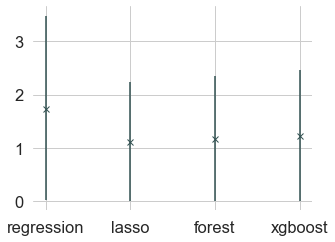

In [38]:
# graphical illustration of RMSE for main regression
errors_irm_rmse = np.full((2, irm_rmse.shape[0]), np.nan)
errors_irm_rmse[0, :] = irm_rmse['main RMSE'] - irm_rmse['main RMSE (sd)']
errors_irm_rmse[1, :] = irm_rmse['main RMSE'] + irm_rmse['main RMSE (sd)']
plt.errorbar(x=irm_rmse.index, y=irm_rmse['main RMSE'], fmt='x',
            yerr=errors_irm_rmse, c='darkslategray')

<ErrorbarContainer object of 3 artists>

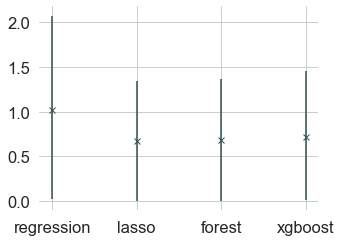

In [39]:
# graphical illustration of log loss for main regression
errors_irm_logloss = np.full((2, irm_rmse.shape[0]), np.nan)
errors_irm_logloss[0, :] = irm_rmse['prop log loss'] - irm_rmse['prop log loss (sd)']
errors_irm_logloss[1, :] = irm_rmse['prop log loss'] + irm_rmse['prop log loss (sd)']
plt.errorbar(x=irm_rmse.index, y=irm_rmse['prop log loss'], fmt='x',
            yerr=errors_irm_logloss, c='darkslategray')

### Inspection of the benchmark model

It is natural to investigate why the the benchmark model performs so much worse than the ML models. First of all, we can conclude that the predictive performance of the linear and logistic regression for the nuisance functions is considerably worse and more variable than for lasso, random forest and xgboost. Moreover, we can also inspect the propensity score estimates of the logistic regression which appear to be very close to zero and one for many observations.

We first define a helper function that generates a histogram of the propensity scores for each of the cross-fitting repetitions.

In [40]:
def rep_propscore_plot(DoubleML):
    """
    A function to create histograms as sublots for every repetition's propensity score density 
    of a Double Machine Learning model
    
    ...
    
    Parameters
    ----------
    DoubleML : doubleml
        The Double Machine Learning model
    """
    
    
    #export nuisance part from the DoubleML model
    m = DoubleML.predictions.get('ml_m')
    
    # dimensions of nuisance array
    h = m.shape[0]
    rep = DoubleML.n_rep
    
    # create histograms as subplots covering the propensity score densities of all repetitions
    fig, ax = plt.subplots(1, rep, figsize=[20,4.8])
    for i in range(rep):
        ax[i].hist(np.reshape(m[:,i], h), range=[0,1], bins=25)
        ax[i].set_title('repetition ' + str(i+1))
        ax[i].set_xlabel("prop_score")
        ax[i].set_ylabel("density")
        
    plt.show()

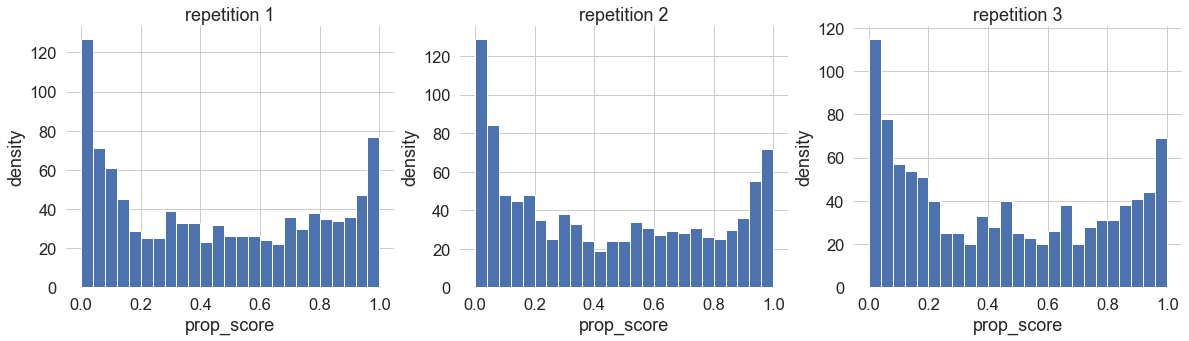

In [41]:
rep_propscore_plot(dml_irm_regression)

Let's compare this to the corresponding plot for the lasso-based model.

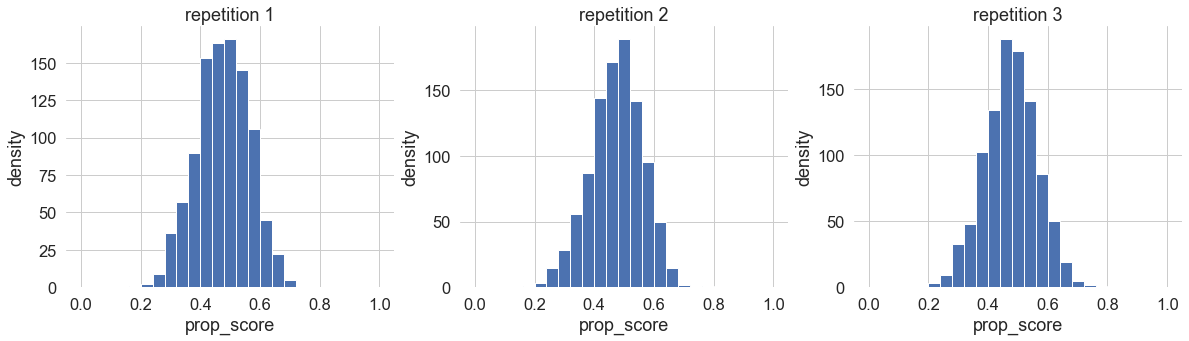

In [42]:
rep_propscore_plot(dml_irm_lasso)

We observe that the propensity score estimates of the lasso-based model are more centered and only close to zero and one for very few observations.

### Conclusion - IRM

We can conclude that the interactive regression model (IRM) estimates are close to the true coefficient value, if the nuisance components are estimated with machine learning methods. The performance of Lasso and the tree-based methods random forests and extreme gradient boosting are comparable. All of the ML-based estimators have exhibited a superior performance to the benchmark based on linear and logistic regression, which seems to be rather unstable in the data example considered.


## 2. Partially Linear Regression Model (PLR)

The [DoubleML](https://docs.doubleml.org/stable/index.html) package also includes the [Partial Linear Regression (PLR)](https://docs.doubleml.org/stable/guide/models.html#partially-linear-regression-model-plr) model, which assumes the population regression has a linear and additive structure. Although in reality, we never know if this structure really holds for the underlying data generating process, we can apply this model and see how the estimates compare to those from the IRM.

We estimate the function $g_0$ and $m_0$ in the following PLR model:

\begin{eqnarray}
& Y = D\theta_0 + g_0(X) + \zeta, &\quad E[\zeta \mid D,X]= 0,\\
& D = m_0(X) +  V, &\quad E[V \mid X] = 0.
\end{eqnarray}

To estimate the causal parameter $\theta_0$, we use double machine learning with 3-fold cross-fitting again. The steps of our analysis are very similar to the IRM cases with the difference being that we use a model class [DoubleMLPLR](https://docs.doubleml.org/stable/api/generated/doubleml.DoubleMLPLR.html) for estimation.

### Assess predictive performance in the PLR

As in the IRM, we want to calculate mean and standard deviation of the RMSE / log loss values across all repetitions to evaluate the prediction performance. Once again, a helper function is used as follows:

In [43]:
def pred_acc_plr(DoubleML, prop):
    """
    A function to calculate prediction accuracy values for every repetition
    of a Double Machine Learning model using PLR, DoubleMLPLR
    
    ...
    
    Parameters
    ----------
    DoubleML : doubleml.double_ml_plr.DoubleMLPLR
        The PLR Double Machine Learning model
    prop : bool
        Indication if RMSE values have to be computed for main regression or log loss values for propensity score
    """
    
    
    # export data, fitted coefficient and predictions of the DoubleML model
    y = DoubleML._dml_data.y
    d = DoubleML._dml_data.d
    theta = DoubleML.coef
    g0 = DoubleML.predictions.get('ml_g')
    m = DoubleML.predictions.get('ml_m')
    
    # dimensions of prediction array
    h = g0.shape[0]
    w = DoubleML.n_rep
    
    # check whether treatment is binary 
    if np.isin(d, [0,1]).all() == False:
        raise ValueError("Treatment must be a binary variable.")
        
    # prepare array to store prediction accuracy values
    pred_acc_array = np.zeros((w,))
    
     # check whether to assess main regression or propensity score accuracy:   
    if prop == False:
        
        # evaluate main regression accuracy
        # export array with prediction values
        export_pred_array = np.zeros((h, w))      
        for i in range(w):
            for j in range(h):
                export_pred_array[j,i] = theta*d[j] + g0[j,i]
        
        # fill array that contains rmse of each repetition
        for i in range(w):
            pred_acc_array[i] = mean_squared_error(y, export_pred_array[:,i], squared=False)
    
    else:
        
        # evaluate propensity score accuracy
        # fill array that contains log loss of each repetition
        for i in range(w):
            pred_acc_array[i] = log_loss(d, m[:,i], eps=0.025)
    
    return pred_acc_array

### Benchmark: Model based on Linear and Logistic Regression

In [81]:
# Initialize Linear and Logistic Regression learners
linreg = make_pipeline(StandardScaler(), LinearRegression())
logreg_class = make_pipeline(StandardScaler(), LogisticRegression(penalty="none"))

# Initialize DoubleMLPLR model
np.random.seed(1234)
dml_plr_regression = dml.DoubleMLPLR(data_dml,
                                     ml_g = linreg,
                                     ml_m = logreg_class,
                                     n_folds = 3,
                                     n_rep = 3)

dml_plr_regression.fit(store_predictions=True)

reg_summary = dml_plr_regression.summary
reg_summary

,coef,std err,t,P>|t|,2.5 %,97.5 %
A,0.784999,0.067127,11.694191,1.364815e-31,0.653432,0.916565


In [45]:
print("Bias:", dml_plr_regression.coef - 0.8)

Bias: [-0.01500149]


In [46]:
# calculate mean and standard deviation of repetition RMSE's to evaluate main regression accuracy
rmse_main_linlog_plr = pred_acc_plr(dml_plr_regression, prop=False)
rmse_main_linlog_plr_mean = np.mean(rmse_main_linlog_plr)
rmse_main_linlog_plr_std = np.std(rmse_main_linlog_plr)

# calculate mean and standard deviation of repetition log losses to evaluate propensity score accuracy
logloss_prop_linlog_plr = pred_acc_plr(dml_plr_regression, prop=True)
logloss_prop_linlog_plr_mean = np.mean(logloss_prop_linlog_plr)
logloss_prop_linlog_plr_std = np.std(logloss_prop_linlog_plr)

In [47]:
print("Mean of the main regression RMSE across 3 repetitions is", rmse_main_linlog_plr_mean)
print("Standard deviation of RMSE is", rmse_main_linlog_plr_std)

Mean of the main regression RMSE across 3 repetitions is 1.3418428467276253
Standard deviation of RMSE is 0.009847706467828324


In [48]:
print("Mean of the propensity score's log loss across 3 repetitions is", logloss_prop_linlog_plr_mean)
print("Standard deviation of log loss is", logloss_prop_linlog_plr_std)

Mean of the propensity score's log loss across 3 repetitions is 1.0228568161263911
Standard deviation of log loss is 0.027536454508812133


### Double Machine Learning based on Lasso

In [49]:
# Initialize DoubleMLPLR model
np.random.seed(1234)
dml_plr_lasso = dml.DoubleMLPLR(data_dml,
                                ml_g = lasso,
                                ml_m = lasso_class,
                                n_folds = 3,
                                n_rep = 3)

dml_plr_lasso.fit(store_predictions=True)

lasso_summary=dml_plr_lasso.summary
lasso_summary

,coef,std err,t,P>|t|,2.5 %,97.5 %
A,0.804795,0.070271,11.452807,2.276523e-30,0.667067,0.942522


In [50]:
print("Bias:", dml_plr_lasso.coef - 0.8)

Bias: [0.00479477]


In [51]:
# calculate mean and standard deviation of repetition RMSE's to evaluate main regression accuracy
rmse_main_lasso_plr = pred_acc_plr(dml_plr_lasso, prop=False)
rmse_main_lasso_plr_mean = np.mean(rmse_main_lasso_plr)
rmse_main_lasso_plr_std = np.std(rmse_main_lasso_plr)

# calculate mean and standard deviation of repetition log losses to evaluate propensity score accuracy
logloss_prop_lasso_plr = pred_acc_plr(dml_plr_lasso, prop=True)
logloss_prop_lasso_plr_mean = np.mean(logloss_prop_lasso_plr)
logloss_prop_lasso_plr_std = np.std(logloss_prop_lasso_plr)

In [52]:
print("Mean of the main regression RMSE across 3 repetitions is", rmse_main_lasso_plr_mean)
print("Standard deviation of RMSE is", rmse_main_lasso_plr_std)

Mean of the main regression RMSE across 3 repetitions is 1.1394799633725696
Standard deviation of RMSE is 0.003190385536736178


In [53]:
print("Mean of the propensity score's log loss across 3 repetitions is", logloss_prop_lasso_plr_mean)
print("Standard deviation of log loss", logloss_prop_lasso_plr_std)

Mean of the propensity score's log loss across 3 repetitions is 0.6686763881131824
Standard deviation of log loss 0.003254281706002184


### Double Machine Learning based on Random Forests

In [54]:
# Initialize Random Forest learners
randomForest = RandomForestRegressor()
randomForest_class = RandomForestClassifier()

# Initialize DoubleMLPLR model
np.random.seed(1234)
dml_plr_forest = dml.DoubleMLPLR(data_dml,
                                 ml_g = randomForest,
                                 ml_m = randomForest_class,
                                 n_folds = 3,
                                 n_rep = 3)

dml_plr_forest.fit(store_predictions=True)

forest_summary = dml_plr_forest.summary
forest_summary

,coef,std err,t,P>|t|,2.5 %,97.5 %
A,0.799307,0.073297,10.905028,1.090595e-27,0.655647,0.942967


In [55]:
print("Bias:", dml_plr_forest.coef - 0.8)

Bias: [-0.00069288]


In [56]:
# calculate mean and standard deviation of repetition RMSE's to evaluate main regression accuracy
rmse_main_forest_plr = pred_acc_plr(dml_plr_forest, prop=False)
rmse_main_forest_plr_mean = np.mean(rmse_main_forest_plr)
rmse_main_forest_plr_std = np.std(rmse_main_forest_plr)

# calculate mean and standard deviation of repetition log losses to evaluate propensity score accuracy
logloss_prop_forest_plr = pred_acc_plr(dml_plr_forest, prop=True)
logloss_prop_forest_plr_mean = np.mean(logloss_prop_forest_plr)
logloss_prop_forest_plr_std = np.std(logloss_prop_forest_plr)

In [57]:
print("Mean of the main regression RMSE across 3 repetitions is", rmse_main_forest_plr_mean)
print("Standard deviation of RMSE is", rmse_main_forest_plr_std)

Mean of the main regression RMSE across 3 repetitions is 1.1886867050333019
Standard deviation of RMSE is 0.006048072563384578


In [58]:
print("Mean of the propensity score's log loss across 3 repetitions is", logloss_prop_forest_plr_mean)
print("Standard deviation of log loss is", logloss_prop_forest_plr_std)

Mean of the propensity score's log loss across 3 repetitions is 0.6836880652313276
Standard deviation of log loss is 0.005321479254441978


### Double Machine Learning based on Extreme Gradient Boosting

In [59]:
# Initialize Extreme Gradient Boosting learners
boost = XGBRegressor(n_jobs = 1, objective = "reg:squarederror",                        
                     eta = 0.1, n_estimators = 57, max_depth = 2)
boost_class = XGBClassifier(use_label_encoder=False, n_jobs=1,
                            objective = "binary:logistic",
                            eval_metric = "logloss",
                            eta = 0.1, n_estimators = 10,
                            max_depth = 3)

# Initialize DoubleMLPLR model
np.random.seed(1234)
dml_plr_boost = dml.DoubleMLPLR(data_dml,
                                ml_g = boost,
                                ml_m = boost_class,
                                n_folds = 3,
                                n_rep = 3)

dml_plr_boost.fit(store_predictions=True)

boost_summary = dml_plr_boost.summary
boost_summary

,coef,std err,t,P>|t|,2.5 %,97.5 %
A,0.82384,0.071676,11.493988,1.414286e-30,0.683358,0.964321


In [60]:
print("Bias:", dml_plr_boost.coef - 0.8)

Bias: [0.02383965]


In [61]:
# calculate mean and standard deviation of repetition RMSE's to evaluate main regression accuracy
rmse_main_boost_plr = pred_acc_plr(dml_plr_boost, prop=False)
rmse_main_boost_plr_mean = np.mean(rmse_main_boost_plr)
rmse_main_boost_plr_std = np.std(rmse_main_boost_plr)

# calculate mean and standard deviation of repetition log losses to evaluate propensity score accuracy
logloss_prop_boost_plr = pred_acc_plr(dml_plr_boost, prop=True)
logloss_prop_boost_plr_mean = np.mean(logloss_prop_boost_plr)
logloss_prop_boost_plr_std = np.std(logloss_prop_boost_plr)

In [62]:
print("Mean of the main regression RMSE across 3 repetitions is", rmse_main_boost_plr_mean)
print("Standard deviation of RMSE is", rmse_main_boost_plr_std)

Mean of the main regression RMSE across 3 repetitions is 1.1560362080432272
Standard deviation of RMSE is 0.0027129250049691073


In [63]:
print("Mean of the propensity score's log loss across 3 repetitions is", logloss_prop_boost_plr_mean)
print("Standard deviation of log loss is", logloss_prop_boost_plr_std)

Mean of the propensity score's log loss across 3 repetitions is 0.677578683851663
Standard deviation of log loss is 0.005774390874769318


#### PLR - Summary of coefficient estimates

In [64]:
plr_summary = pd.concat((reg_summary, lasso_summary, forest_summary, boost_summary))
plr_summary.index = ['regression','lasso', 'forest', 'xgboost']
plr_summary = plr_summary[['coef', 'std err', '2.5 %', '97.5 %']]
plr_summary.insert(1, "Bias", [plr_summary.loc['regression','coef'] - 0.8, 
                               plr_summary.loc['lasso','coef'] - 0.8, 
                               plr_summary.loc['forest','coef'] - 0.8, 
                               plr_summary.loc['xgboost','coef'] - 0.8])
plr_summary.round(3) 

,coef,Bias,std err,2.5 %,97.5 %
regression,0.785,-0.015,0.067,0.653,0.917
lasso,0.805,0.005,0.070,0.667,0.943
forest,0.799,-0.001,0.073,0.656,0.943
xgboost,0.824,0.024,0.072,0.683,0.964


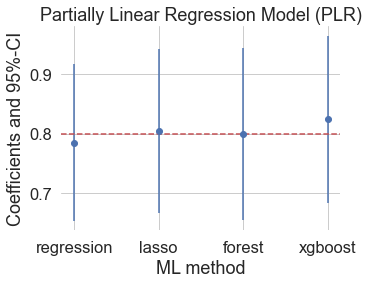

In [65]:
errors = np.full((2, plr_summary.shape[0]), np.nan)
errors[0, :] = plr_summary['coef'] - plr_summary['2.5 %']
errors[1, :] = plr_summary['97.5 %'] - plr_summary['coef']
plt.errorbar(plr_summary.index, plr_summary.coef, fmt='o', yerr=errors)
plt.axhline(y=0.8, color='r', linestyle='--', label="true value")

plt.title('Partially Linear Regression Model (PLR)')
plt.xlabel('ML method')
_ = plt.ylabel('Coefficients and 95%-CI')

#### PLR - Summary of prediction accuracy metric's mean values

In [66]:
plr_rmse_index = ['regression','lasso', 'forest', 'xgboost']
plr_rmse = pd.DataFrame([[rmse_main_linlog_plr_mean, rmse_main_linlog_plr_std,                          
                         logloss_prop_linlog_plr_mean, logloss_prop_linlog_plr_std],
                         [rmse_main_lasso_plr_mean, rmse_main_lasso_plr_std,
                          logloss_prop_lasso_plr_mean, logloss_prop_lasso_plr_std],
                         [rmse_main_forest_plr_mean, rmse_main_forest_plr_std,
                          logloss_prop_forest_plr_mean, logloss_prop_forest_plr_std],
                         [rmse_main_boost_plr_mean, rmse_main_boost_plr_std,
                          logloss_prop_boost_plr_mean, logloss_prop_boost_plr_std]],
                        index=plr_rmse_index,
                        columns=['main RMSE', 'main RMSE (sd)',
                                 'prop log loss', 'prop log loss (sd)'])
plr_rmse.round(3)

,main RMSE,main RMSE (sd),prop log loss,prop log loss (sd)
regression,1.342,0.010,1.023,0.028
lasso,1.139,0.003,0.669,0.003
forest,1.189,0.006,0.684,0.005
xgboost,1.156,0.003,0.678,0.006


<ErrorbarContainer object of 3 artists>

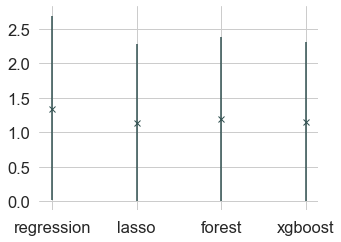

In [67]:
# graphical illustration of RMSE for main regression
errors_plr_rmse = np.full((2, plr_rmse.shape[0]), np.nan)
errors_plr_rmse[0, :] = plr_rmse['main RMSE'] - plr_rmse['main RMSE (sd)']
errors_plr_rmse[1, :] = plr_rmse['main RMSE'] + plr_rmse['main RMSE (sd)']
plt.errorbar(x=plr_rmse.index, y=plr_rmse['main RMSE'], fmt='x',
            yerr=errors_plr_rmse, c='darkslategray')

<ErrorbarContainer object of 3 artists>

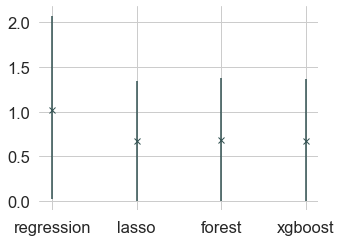

In [68]:
# graphical illustration of log loss for main regression
errors_plr_logloss = np.full((2, plr_rmse.shape[0]), np.nan)
errors_plr_logloss[0, :] = plr_rmse['prop log loss'] - plr_rmse['prop log loss (sd)']
errors_plr_logloss[1, :] = plr_rmse['prop log loss'] + plr_rmse['prop log loss (sd)']
plt.errorbar(x=plr_rmse.index, y=plr_rmse['prop log loss'], fmt='x',
            yerr=errors_plr_logloss, c='darkslategray')

### Summary of IRM and PLR Results

In [69]:
df_summary = pd.concat((irm_summary,plr_summary)).reset_index().rename(columns={'index': 'ML'})
df_summary['Model'] = np.concatenate((np.repeat('IRM', 4), np.repeat('PLR', 4)))
df_summary.set_index(['Model', 'ML']).round(3)

coef   Bias  std err  2.5 %  97.5 %
Model ML                                              
IRM   regression  1.058  0.258    0.625 -0.167   2.282
      lasso       0.856  0.056    0.071  0.717   0.995
      forest      0.893  0.093    0.077  0.741   1.045
      xgboost     0.791 -0.009    0.104  0.586   0.995
PLR   regression  0.785 -0.015    0.067  0.653   0.917
      lasso       0.805  0.005    0.070  0.667   0.943
      forest      0.799 -0.001    0.073  0.656   0.943
      xgboost     0.824  0.024    0.072  0.683   0.964

### Conclusion

As in the IRM model, the ML-based PLR models are associated with a smaller bias as compared to the model that is based on linear and logistic regression. It seems that the estimates obtained from the PLR are slightly closer to the true ATE than those from the IRM analysis. This might suggest, that the parametric assumptions (i.e., an additive and homogeneous causal effect) that are incorporated in the PLR turn out to be **not restrictive** in our example data set. However, if both models are based on appropriate ML learners, the conclusions are very similar. In all cases, the ML-based estimates were very close to the true ATE and we were always able to reject the null hypothesis of a zero effect at all common significance levels. In terms of the A/B testing example, it can be concluded that the new ad increases customers purchases (in $100\$$) by around 0.8 on average and that this effect is significantly different from zero at the 5% significance level. The results are summarized in the graphic below.

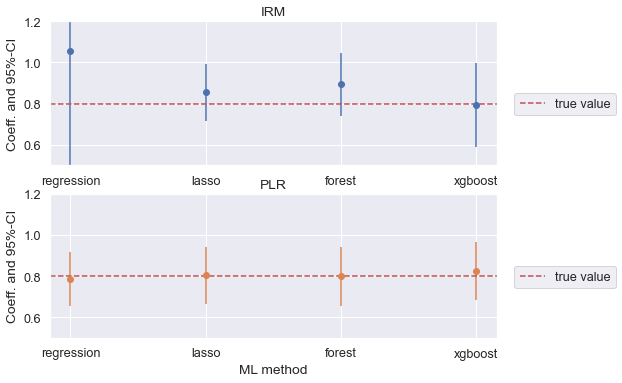

In [70]:
plt.figure(figsize=(8, 9))
colors = sns.color_palette()
for ind, model in enumerate(['IRM', 'PLR']):
    sns.set(font_scale=1.15)
    plt.subplot(3, 1, ind+1)
    this_df = df_summary.query('Model == @model')
    errors = np.full((2, this_df.shape[0]), np.nan)
    errors[0, :] = this_df['coef'] - this_df['2.5 %']
    errors[1, :] = this_df['97.5 %'] - this_df['coef']
    plt.errorbar(this_df.ML, this_df.coef, fmt='o', yerr=errors,
                 color=colors[ind], ecolor=colors[ind])
    plt.ylim([0.5, 1.2])
    plt.title(model)
    plt.ylabel('Coeff. and 95%-CI')
    plt.axhline(y=0.8, color='r', linestyle='--', label="true value")
    plt.legend(bbox_to_anchor=(1.04,0.5), loc="best", borderaxespad=0)

_ = plt.xlabel('ML method')

## Appendix

### Propensity score estimates

For both the IRM and the PLR model, we want to compare the propensity score estimates of all learners. Since repeated sample splitting is used for every learner, we first want to check whether the repetitions provide similare propensity score estimates. If that is the case, it should be legitimate to pick any of the repetitions for the comparision across all learners.

#### IRM - Repetitions of the Linear and Logistic regression model

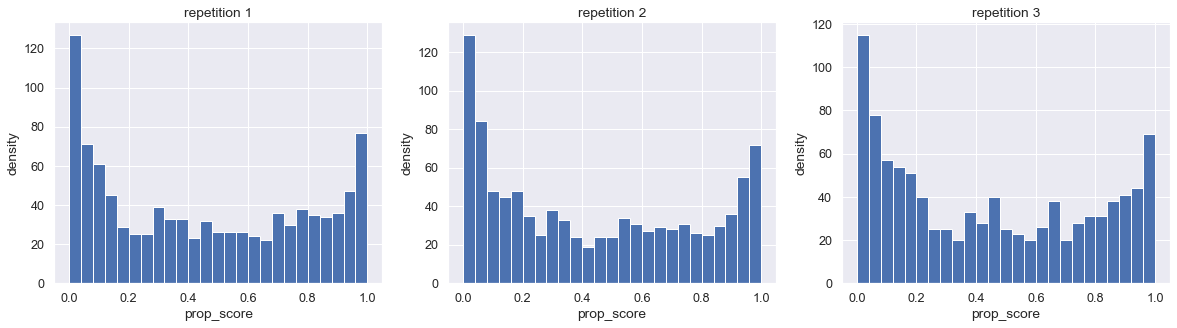

In [71]:
rep_propscore_plot(dml_irm_regression)

#### IRM - Repetitions of the Lasso model

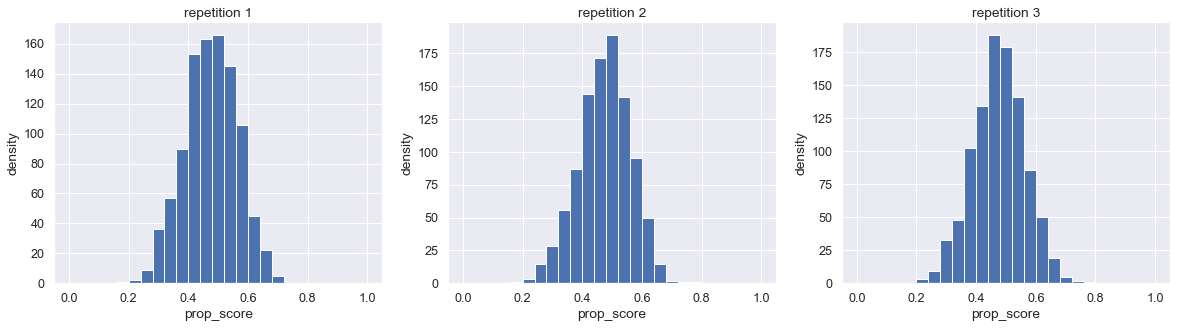

In [72]:
rep_propscore_plot(dml_irm_lasso)

#### IRM - Repetitions of the Random Forest model

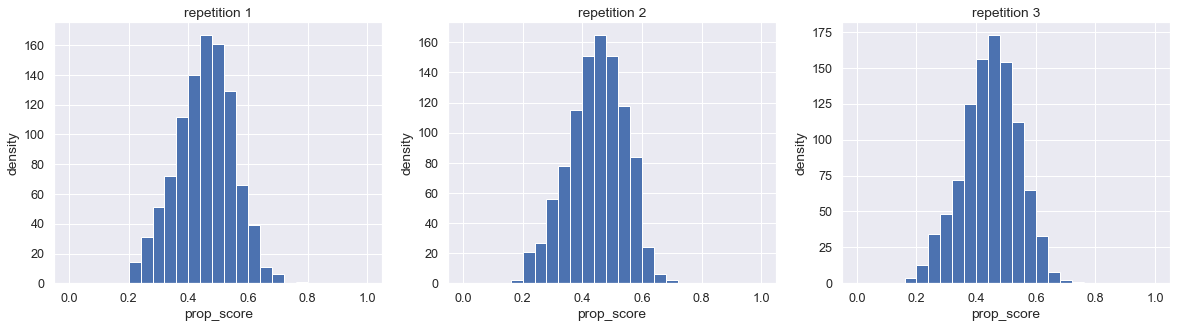

In [73]:
rep_propscore_plot(dml_irm_forest)

#### IRM - Repetitions of the Extreme Gradient Boosting model

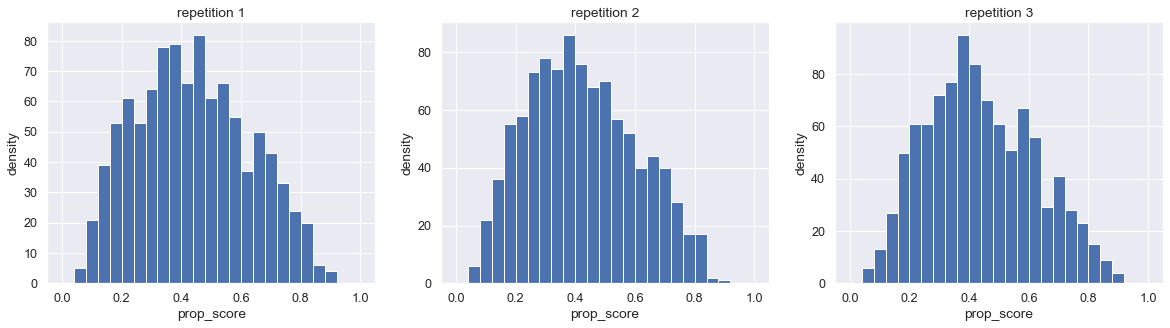

In [74]:
rep_propscore_plot(dml_irm_boost)

#### IRM - Propensity score estimates across learners

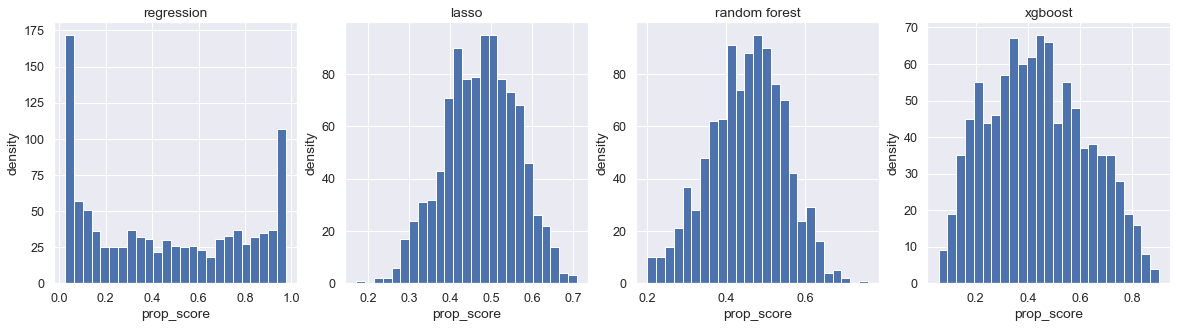

In [75]:
h = dml_irm_regression.predictions.get('ml_m').shape[0]
fig, ax = plt.subplots(1, 4, figsize=(20,4.8))

#regression histogram
ax[0].hist(np.reshape(dml_irm_regression.predictions.get('ml_m')[:,0], h), bins=25)
ax[0].set_title('regression')
ax[0].set_xlabel("prop_score")
ax[0].set_ylabel("density")

#lasso histogram
ax[1].hist(np.reshape(dml_irm_lasso.predictions.get('ml_m')[:,0], h), bins=25)
ax[1].set_title('lasso')
ax[1].set_xlabel("prop_score")
ax[1].set_ylabel("density")

#random forest histogram
ax[2].hist(np.reshape(dml_irm_forest.predictions.get('ml_m')[:,0], h), bins=25)
ax[2].set_title('random forest')
ax[2].set_xlabel("prop_score")
ax[2].set_ylabel("density")

#boosting histogram
ax[3].hist(np.reshape(dml_irm_boost.predictions.get('ml_m')[:,0], h), bins=25)
ax[3].set_title('xgboost')
ax[3].set_xlabel("prop_score")
ax[3].set_ylabel("density")
           
plt.show()

#### PLR - Repetitions of the Linear and Logistic regression model

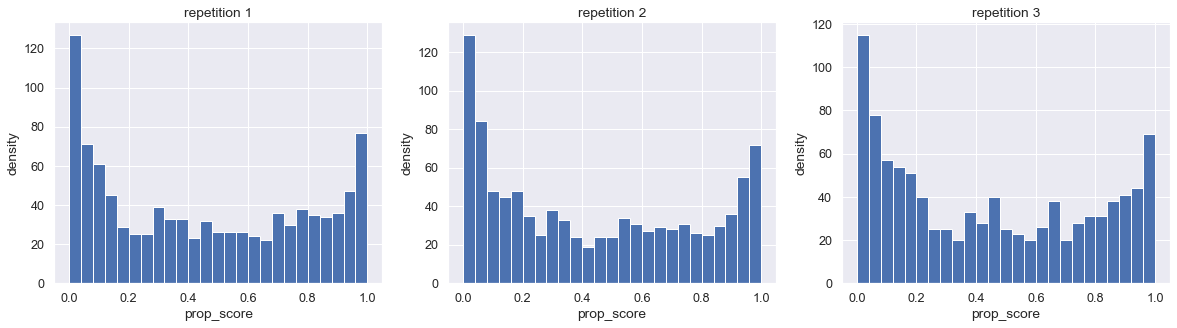

In [76]:
rep_propscore_plot(dml_plr_regression)

#### PLR - Repetitions of the Lasso model

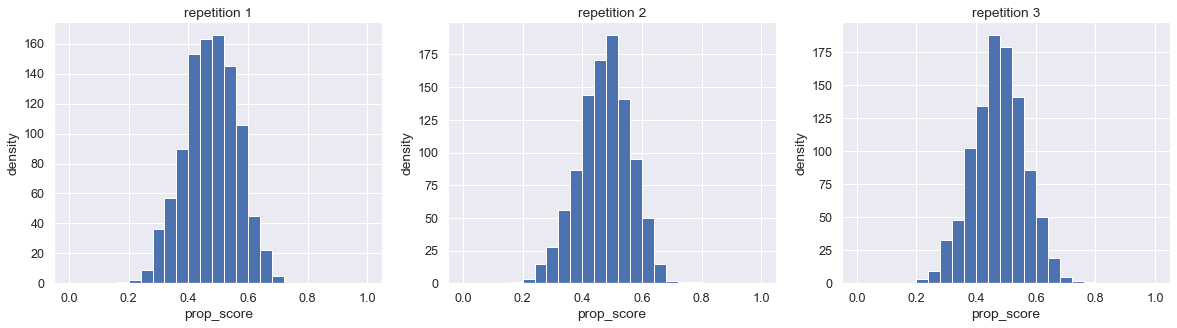

In [77]:
rep_propscore_plot(dml_plr_lasso)

#### PLR - Repetitions of the Random Forest model

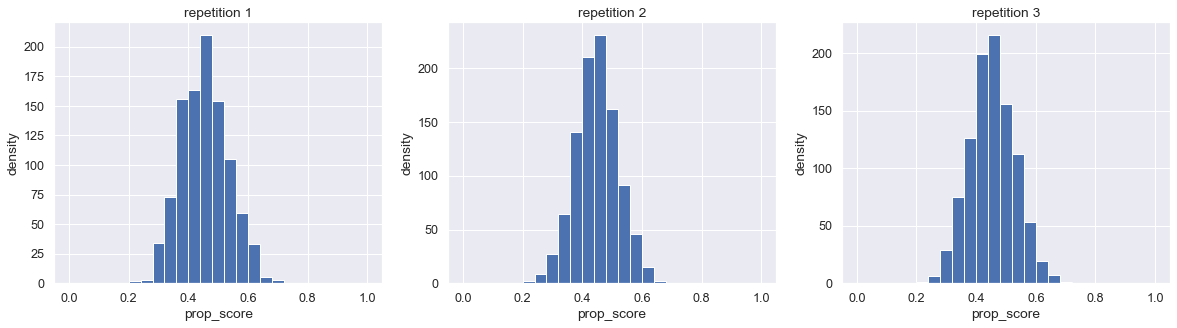

In [78]:
rep_propscore_plot(dml_plr_forest)

#### PLR - Repetitions of the Extreme Gradient Boosting model

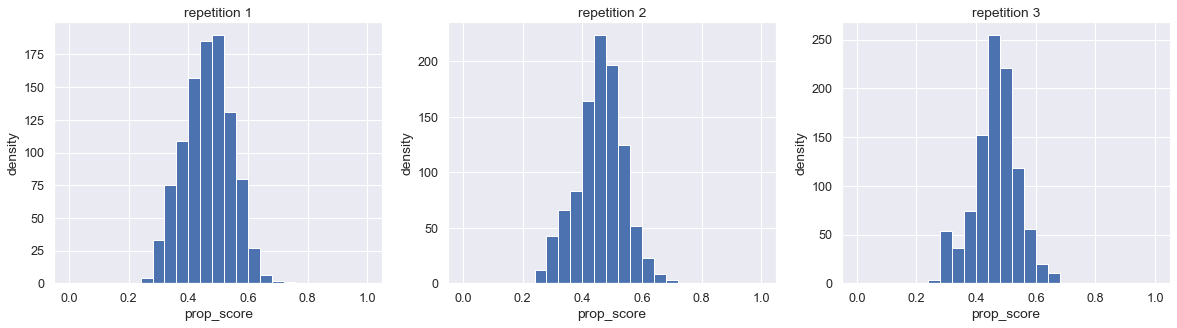

In [79]:
rep_propscore_plot(dml_plr_boost)

#### PLR - Propensity score estimates across learners

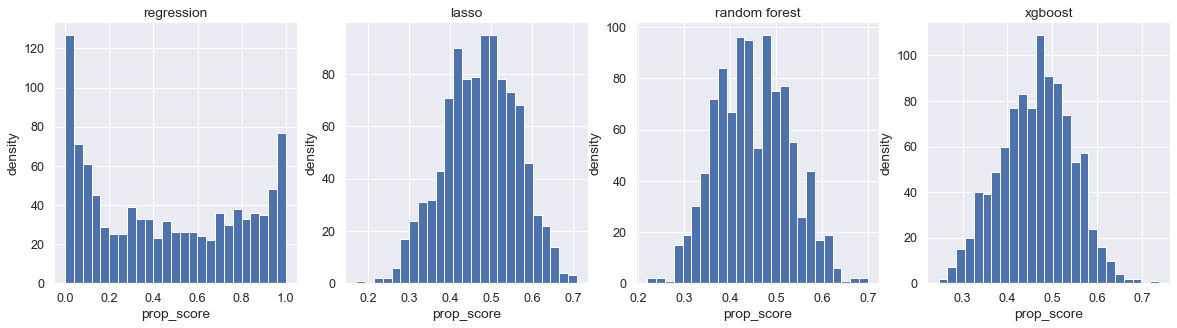

In [80]:
h = dml_plr_regression.predictions.get('ml_m').shape[0]
fig, ax = plt.subplots(1, 4, figsize=(20,4.8))

#regression histogram
ax[0].hist(np.reshape(dml_plr_regression.predictions.get('ml_m')[:,0], h), bins=25)
ax[0].set_title('regression')
ax[0].set_xlabel("prop_score")
ax[0].set_ylabel("density")

#lasso histogram
ax[1].hist(np.reshape(dml_plr_lasso.predictions.get('ml_m')[:,0], h), bins=25)
ax[1].set_title('lasso')
ax[1].set_xlabel("prop_score")
ax[1].set_ylabel("density")

#random forest histogram
ax[2].hist(np.reshape(dml_plr_forest.predictions.get('ml_m')[:,0], h), bins=25)
ax[2].set_title('random forest')
ax[2].set_xlabel("prop_score")
ax[2].set_ylabel("density")

#boosting histogram
ax[3].hist(np.reshape(dml_plr_boost.predictions.get('ml_m')[:,0], h), bins=25)
ax[3].set_title('xgboost')
ax[3].set_xlabel("prop_score")
ax[3].set_ylabel("density")
           
plt.show()

______

**Notes and Acknowledgement**

We would like to thank the organizers of the [ACIC 2019 Data Challenge](https://sites.google.com/view/acic2019datachallenge/data-challenge) for setting up this data challenge and making the numerous synthetic data examples publicly available.  Although the data examples in the [ACIC 2019 Data Challenge](https://sites.google.com/view/acic2019datachallenge/data-challenge) do not explicitly adress A/B testing, we put the data example here in this context to give a tractable example on the use of causal machine learning in practice. The parameters for the random forests and extreme gradient boosting learners have been tuned externally. The corresponding tuning notebook will be uploaded in the [examples gallery](https://docs.doubleml.org/dev/examples/index.html) in the future.

## References

Chernozhukov, V., Chetverikov, D., Demirer, M., Duflo, E., Hansen, C., Newey, W. and Robins, J. (2018), Double/debiased machine learning for treatment and structural parameters. The Econometrics Journal, 21: C1-C68. doi:10.1111/ectj.12097.